In [298]:
from sklearn.model_selection import train_test_split
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import os.path
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [299]:
plot_predictions = False

data_path = 'data'
categories = ['a', 'b', 'l', 'p', 'o', 'k', 's']

data = []
labels = []

In [300]:
for category in categories:
    category_path = os.path.join(data_path, category)
    class_num = categories.index(category)
    for img in os.listdir(category_path):
        try:
            img_path = os.path.join(category_path, img)
            img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            data.append(img_array)
            labels.append(class_num)
        except Exception as e:
            pass

data = np.array(data) / 255.0
data = np.reshape(data, (data.shape[0], 16, 16, 1))
labels = np.array(labels)

In [301]:
def save_model(model):
    model.save('model.h5')

In [302]:
def load_model():
    if os.path.isfile('model.h5'):
        model = tf.keras.models.load_model('model.h5')
        return model, True

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(16, 16, 1)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(len(categories), activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model, False

In [303]:
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.1)

model, loaded = load_model()

if not loaded:
    model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

    save_model(model)

predictions = model.predict(X_test)

predicted_labels = np.argmax(predictions, axis=1)

predicted_labels = np.argmax(predictions, axis=1)


1/1 [==============================] - 0s 42ms/step


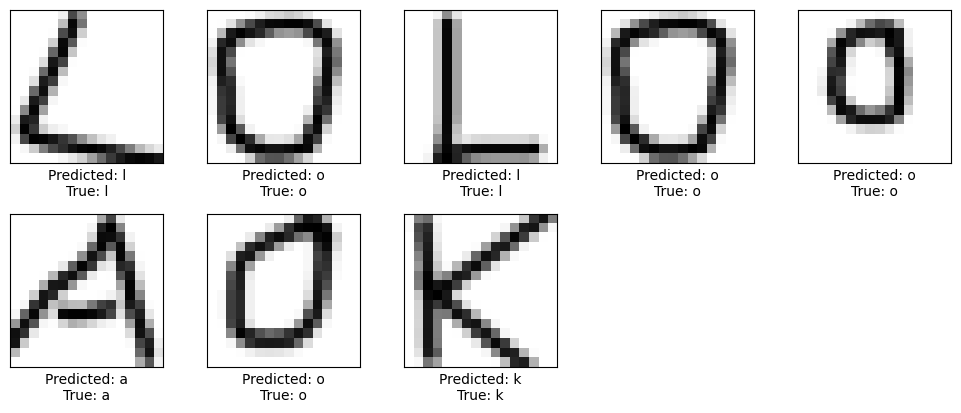

Accuracy: 1.0


In [304]:
plot_predictions = True

if plot_predictions:
    plt.figure(figsize=(10, 10))
    accuracy = 0

    for i in range(len(X_test)):
        plt.subplot(5, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X_test[i].reshape(16, 16), cmap='gray')
        plt.xlabel(
            f"Predicted: {categories[predicted_labels[i]]}\nTrue: {categories[y_test[i]]}")
        if predicted_labels[i] == y_test[i]:
            accuracy += 1

    plt.tight_layout()

    plt.show()

    print(f"Accuracy: {accuracy/len(X_test)}")

Number of contours found: 4
1/1 [==============================] - 0s 16ms/step
[[0. 0. 0. 0. 0. 1. 0.]]
k
1/1 [==============================] - 0s 14ms/step
[[1. 0. 0. 0. 0. 0. 0.]]
a
1/1 [==============================] - 0s 14ms/step
[[1. 0. 0. 0. 0. 0. 0.]]
a
1/1 [==============================] - 0s 14ms/step
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 2.3033032e-05 0.0000000e+00
  0.0000000e+00 9.9997699e-01]]
s


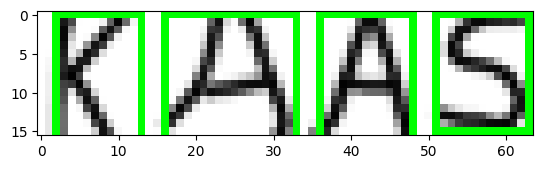

Word: kaas


In [309]:
word_img_path = 'data/word.png'

image = cv2.imread(word_img_path)

gray = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2GRAY)

ret, im = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)

contours, hierarchy = cv2.findContours(
    im, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(f"Number of contours found: {len(contours)}")

letter_boxes = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if w > 1 and h > 1:
        letter_boxes.append((x, y, w, h))

letter_boxes = sorted(letter_boxes, key=lambda x: x[0])

image_with_boxes = image.copy()

image_with_boxes = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)

predictions = []
word = ""

for i, letter_boxes in enumerate(letter_boxes):
    x, y, w, h = letter_boxes
    letter_image = im[y:y+h, x:x+w]

    letter_image = cv2.bitwise_not(letter_image)

    letter_image = cv2.resize(letter_image, (16, 16))

    # plt.imshow(letter_image)
    # plt.show()

    letter_image = np.reshape(letter_image, (1, 16, 16, 1))

    prediction = model.predict(letter_image)
    print(prediction)
    predicted_label = np.argmax(prediction, axis=1)

    cv2.rectangle(image_with_boxes, (x, y), (x+w, y+h), (0, 255, 0), 1)

    print(categories[predicted_label[0]])
    word += categories[predicted_label[0]]

plt.imshow(image_with_boxes)
plt.show()

print(f"Word: {word}")